In [369]:
import requests
import json
import nferx_py.fn as nf
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import pool
import seaborn as sns
from tqdm import tqdm
from nltk.stem import SnowballStemmer
from gensim.utils import simple_preprocess
import numpy as np
from tqdm.notebook import tqdm
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import auc

In [2]:
stemmer = SnowballStemmer('english')

In [3]:
nf.authenticate('nfer','6eaa1d27bfa0639f2712191fa55df872')
nf.modify_defaults('server', 'preview')
nf.modify_defaults('api_server', 'preview')
AUTH = nf.AUTH

2020-05-13 11:56:00,120 : INFO : Authentication successful - nferX is online
2020-05-13 11:56:00,121 : INFO : Default parameter server modified
2020-05-13 11:56:00,122 : INFO : Default parameter api_server modified


### notes
1. Get local scores for all gene/cell combinations from single cell api for Tabula muris (study 2) and mouse cell atlas (study 15)
2. Do "intra-study" testing: for each Tabula Muris cluster, (1) identify the subset of genes to consider (e.g. top 0.05% by cohen's D vs. all other cells), (2) calculate cosine similarity between mean CP10K vector of this gene subset and the literature score vectors for all Tabula Muris cell types with this same gene subset. This would give us a ranked list of literature-derived labels for each cluster. Then repeat this with Mouse Cell Atlas. ---- Cosine sim did not work out---- Switched to calculating vector norms of literature scores of top genes from selected from cluster A, accross all clusters 

- For each cluster to label C:
    1. Select the top n genes by Cohen’s D (e.g. top 5, 10, 25)
    2. From API, get the fraction of cells in cluster C which express each gene
    3. From literature reference table, get the local scores between each reference cell type and the top n genes
    4. Multiply “Fraction cells expressing in cluster C” column by each “Ref_CellTypeX_LocalScores” column to get a set of “literature encoded expression vectors” for each reference cell type
    5. For each “Lit Encoded Vector” column, calculate L0, L1, L2, and L-inf norms
        L0: number of non-zero elements
        L1: sum of all values
        L2: square root of sum of squares
        L-inf: max value
    Output: four tables of Clusters To Label (rows) * Reference Cell Types 
    Table 1 = L0 norm, Table 2 = L1 norm, Table 3 = L2 norm, Table 4 = L-inf norm
    
-----------
Update: 05/15

use global scores

-------------step 4 yet to be done------------------------
4. Do "inter-study" testing: for each Tabula Muris cluster, (1) identify the subset of genes to consider (e.g. top 0.05% by cohen's D vs. all other cells), (2) calculate cosine similarity between mean CP10K vector of this gene subset and the literature score vectors for all Mouse Cell Atlas cell types with this same gene subset. Then repeat this to label all Mouse Cell Atlas clusters using the literature vectors from the Tabula Muris dataset. This will require some handling of synonyms/cell "families" which I provided to Katie for this analysis ... but we could go over that later since step 2 alone will take some time to set up and optimize I think

### POST to single cell api to get the table

In [889]:
URL = 'https://pre-staging.nferx.com/singlecellapi/study2/summary?'
headers = {'content-type' : 'application/json'}
res = requests.post(url = URL, params = {'page': 1, 'rows': 3412880}, auth = AUTH)
data_all = pd.DataFrame(res.json()['result']['data'])
# d.drop(columns=['localScoreCellType', 'localScoreTissueType', 'greaterThanZero'], inplace = True)
data_all_backup = data_all.copy(deep = True)
# data_all.drop(columns=['localScoreTissueType', 'greaterThanZero'], inplace = True)


### litreature vectors

In [948]:
class Literature_model():

    def __init__(self, data = data_all, savepath = './data/results/global_score/', use_score = ''):
        
        data['Score'] = [d[use_score] for d in data.localScoreCellType]
        data['cluster'] = data.cellType.str.replace(' ', '_') + ';'+data.tissueType.str.replace(' ', '_')
        self.gene_cluster_score = data.pivot(index = 'geneName', 
                                                  columns = 'cluster',
                                                  values = 'Score')
    
        self.savepath = savepath
        self.dfs_all = dict() 
        
    def get_top_genes_vector(self, df, top_n = None, quantile = 0.995, cols = ['cohenD', 'mean', 'greaterThanZero']):
        #matrix 1: top-genes means (shape: 1*N)
        df = df.set_index('geneName')
        if top_n:
            return df.sort_values(by = 'cohenD', ascending = False)[cols].iloc[0:top_n]

        cutoff = df.cohenD.quantile([0.995]).values[0]
        top_genes_vec = df.loc[df.cohenD >= cutoff, cols]


        return top_genes_vec
    
    def get_measure_matrix(self, top_genes_subset, metric = 'cosine'):
        cluster = top_genes_subset.cluster[0]
        #matrix 1: top-genes means (shape: 1*N)
        top_genes_mean = top_genes_subset.loc[:, ['geneName', 'mean']].set_index('geneName').transpose()
        #matrix 2: top-genes(N) vs all - clusters'(M) local score (shape: N*M)
        gene_local_score_subset = self.gene_cluster_score.loc[top_genes_mean.columns,:]

        #get literature vector
        lit_encoded_subset = gene_local_score_subset.multiply(top_genes_subset.loc[:, 'greaterThanZero'].values, 
                                                                  axis = 0)

        #apply norms

        if metric == 'norm-all':
            score0 = (lit_encoded_subset != 0).sum()
            score1 = lit_encoded_subset.sum()
            score2 = lit_encoded_subset.pow(2).sum().pow(1/2)
            scoreINF = lit_encoded_subset.max()

            return [score0, score1, score2, scoreINF]

        elif metric == 'cosine':
            assert top_genes_mean.shape[1] == lit_encoded_subset.shape[0]
            score = cosine_similarity(top_genes_mean.to_numpy(), lit_encoded_subset.transpose())
            score = pd.Series(score.reshape(-1), index = lit_encoded_subset.columns)
        elif metric == 'l0':
            score = (lit_encoded_subset != 0).sum()
        elif metric == 'l1':
            score = lit_encoded_subset.sum()
        elif metric == 'l2':
            score = lit_encoded_subset.pow(2).sum().pow(1/2)
        elif metric == 'inf':
            score = lit_encoded_subset.max()

        return score
    
    
    #top n genes; all norrms
    def use_measure(self, n_genes = [5, 10, 25], metric = 'norm-all', 
                    save = False):
        for n in n_genes:
            cluster_mean_vectors = data_all.groupby('cluster').apply(lambda x: self.get_top_genes_vector(x, top_n = n))
            cluster_mean_vectors.loc[:, 'greaterThanZero'] = cluster_mean_vectors.loc[:, 'greaterThanZero']/100
            cluster_mean_vectors = cluster_mean_vectors.reset_index()
            res = cluster_mean_vectors.groupby('cluster').apply(lambda x: self.get_measure_matrix(x, metric))
            if metric == 'norm-all':
                norms = ['L0', 'L1', 'L2', 'Linf']
                for i, norm in enumerate(norms):
                    name = '{}_{:02}'.format(norm, n)
                    df = res.apply(lambda x: x[i])
                    self.dfs_all[name] = df
                    if save:
                        df.index = df.index + '_TRUE'
                        df.to_csv(self.savepath+'{}_{:02}_genes.csv'.format(norm, n))
            else:
                name = '{}_{:02}'.format(metric, n)
                self.dfs_all[name] = res
                if save:
                    res.index = res.index + '_TRUE'
                    res.to_csv(self.savepath+'{}_{:02}_genes.csv'.format(metric, n))
        return dfs

    
    def run(self, metric = ['cosine', 'norm-all']):
        
        _ = list(map(lambda x: self.use_measure(metric = x, save = True), metric))
        self.get_ranks()
        
    def get_ranks(self):
        metric_rank_df = pd.DataFrame(range(0,97), columns=['rank'])
        #mappings frorm pat
        cell_maps = pd.read_csv('./data/TM_clusters_map.csv')
        cell_maps.set_index('cluster', inplace=True)
        for key, df in self.dfs_all.items():
#             df = pd.read_csv(self.savepath+file, index_col = 0)
            df.columns = df.index = df.columns.str.replace(';|-', '.') 
            df.columns = df.index = cell_maps.loc[df.columns, 'map'] 
            ranks_all = df.T.reset_index().drop_duplicates().set_index('map').apply(lambda x: 
                                                        x.sort_values(ascending = False).index, 
                                                        axis = 0).reset_index(drop = True).apply(lambda x:
                                                        x[x.name == x].index.to_list())
            cluster_ranks = ranks_all.apply(lambda x:x[0])
            metric_rank_df[key] = metric_rank_df.loc[:,'rank'].apply(lambda x: 
                                                                               (cluster_ranks < x).sum()/148)


        metric_rank_df['rank'] = metric_rank_df['rank']/96
        var_name_ = 'Measure_Top N genes'
        self.plot_df = metric_rank_df.melt(id_vars = 'rank', 
                                           var_name = var_name_,
                                           value_name='n_top_rank_clusters')
        
        self.plot_df['norm'] = list(map(lambda x: x[0], self.plot_df[var_name_].str.split('_')))
        self.plot_df['n_top_genes'] = list(map(lambda x: str(x[1]), self.plot_df[var_name_].str.split('_')))
        self.plot_df['n_top_genes'] = self.plot_df.n_top_genes.astype('category')
        
        auc_ = self.plot_df.groupby(['norm', 
                                'n_top_genes']).apply(lambda x: 
                                    auc(x['rank'], x['n_top_rank_clusters'])).to_frame(name = 'auc').reset_index()

        self.plot_df = pd.merge(self.plot_df, auc_, how = 'left', on = ['norm', 'n_top_genes'])
        self.plot_df[var_name_ + ' | AUC'] = self.plot_df[var_name_] +  ' | ' + self.plot_df['auc'].round(3).astype(str)
    
            
#     files = os.listdir(self.savepath)
    #investigating low perfonming clusters
    def get_ranks_for_file(self, filename):
        df = pd.read_csv(filename, index_col = 0)
        idx_true = df.index.str.rstrip('_TRUE')
        idx_true.name = 'cluster'
        df.columns = df.index = df.columns.str.replace(';|-', '.') 
        df.columns = df.index = cell_maps.loc[df.columns, 'map'] 

        ranks_all = df.T.reset_index().drop_duplicates().set_index('map').apply(lambda x: 
                                                                              x.sort_values(ascending = False).index, 
                                     axis = 0).reset_index(drop = True).apply(lambda x:
                                                                              x[x.name == x].index.to_list())

        ranks_all = ranks_all.apply(lambda x: x[0]).to_frame(name = 'rank')
        ranks_all.index = idx_true
        return ranks_all.sort_values(by = 'rank'), df

In [949]:
%%time
c = Literature_model(data = data_all, use_score='localScore')
c.run()

CPU times: user 7.99 s, sys: 741 ms, total: 8.73 s
Wall time: 8.78 s


In [957]:
c.plot_df

,rank,Measure_Top N genes,n_top_rank_clusters,norm,n_top_genes,auc,Measure_Top N genes | AUC
0,0.000000,cosine_05,0.000000,cosine,05,0.786669,cosine_05 | 0.787
1,0.010417,cosine_05,0.094595,cosine,05,0.786669,cosine_05 | 0.787
2,0.020833,cosine_05,0.168919,cosine,05,0.786669,cosine_05 | 0.787
3,0.031250,cosine_05,0.175676,cosine,05,0.786669,cosine_05 | 0.787
4,0.041667,cosine_05,0.229730,cosine,05,0.786669,cosine_05 | 0.787
...,...,...,...,...,...,...,...
1450,0.958333,Linf_25,0.986486,Linf,25,0.845650,Linf_25 | 0.846
1451,0.968750,Linf_25,1.000000,Linf,25,0.845650,Linf_25 | 0.846
1452,0.979167,Linf_25,1.000000,Linf,25,0.845650,Linf_25 | 0.846
1453,0.989583,Linf_25,1.000000,Linf,25,0.845650,Linf_25 | 0.846


Text(0, 0.5, 'Fractions of Clusters Labeled Correctly')

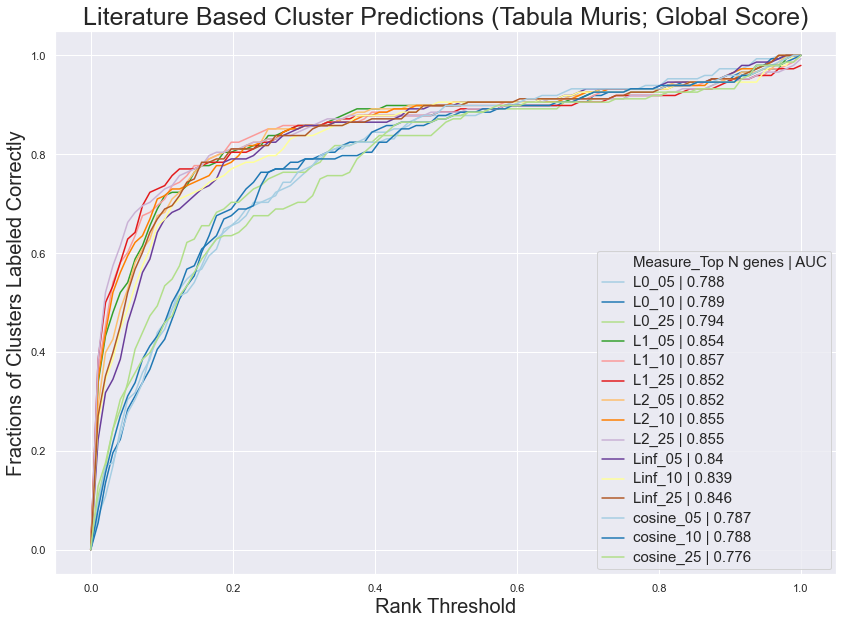

In [956]:
sns.set()
var_name_ =  'Measure_Top N genes | AUC'
fig = plt.figure(figsize=(14,10))

ax = sns.lineplot(data = c.plot_df, 
             x = 'rank', 
             y = 'n_top_rank_clusters',
             hue=var_name_, hue_order=sorted(c.plot_df[var_name_].unique()),
             palette=sns.color_palette("Paired", 15))
plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20')
ax.axes.set_title("Literature Based Cluster Predictions (Tabula Muris; Global Score)",fontsize=25)
ax.set_xlabel("Rank Threshold",fontsize=20)
ax.set_ylabel("Fractions of Clusters Labeled Correctly",fontsize=20)

In [777]:
plt.savefig('./plots/lit_prredictions_auc.png')

<Figure size 432x288 with 0 Axes>

### some exploration

In [805]:
cluster_mean_vectors = data_all.groupby('cluster').apply(lambda x: get_top_genes_vector(x, top_n = 5))

In [806]:
cluster_mean_vectors

cohenD      mean  greaterThanZero
cluster                   geneName                                     
Alveolar_macrophages;lung Chi3l3    2.911539  4.482258       100.000000
                          Tmsb4x    2.888863  5.654968       100.000000
                          Sepx1     2.431341  2.659609        99.420290
                          Cd44      2.388964  2.767570        99.710145
                          Serf2     2.347590  3.166469        99.710145
...                                      ...       ...              ...
type_II_pneumocytes;lung  Sftpb     4.507700  5.003388       100.000000
                          Sftpc     4.118964  7.447270       100.000000
                          Sftpa1    3.522555  5.416618       100.000000
                          Sfta2     3.050134  2.864463        96.629213
                          Sftpd     2.991714  3.619013       100.000000

[740 rows x 3 columns]

In [831]:
# lc.columns = lc.columns.str.replace(';|-', '.') 

# rank_df.to_csv('./data/ranks_l1_25_global_score.csv')

# l = df.T.reset_index().drop_duplicates().set_index('map').apply(lambda x: 
#                                                                           x.sort_values(ascending = False).index, 
#                                  axis = 0).reset_index(drop = True).iloc[0:9, -1].to_list()

# df.T.reset_index().drop_duplicates().set_index('map').apply(lambda x: 
#                                                                           x.sort_values(ascending = False).index, 
#                                  axis = 0).reset_index(drop = True)

# cell_maps.loc[cell_maps['map'].isin(l)]
# lc = pd.read_csv('./data/local_score_top_25_type_II_pneumocytes.csv', index_col = 0)

### Preevious 

In [61]:
cluster_mean_vectors.loc[slice('Alveolar_macrophages;lung')]

cohenD      mean  greaterThanZero
cluster                   geneName                                     
Alveolar_macrophages;lung Chi3l3    2.911539  4.482258       100.000000
                          Tmsb4x    2.888863  5.654968       100.000000
                          Sepx1     2.431341  2.659609        99.420290
                          Cd44      2.388964  2.767570        99.710145
                          Serf2     2.347590  3.166469        99.710145

In [ ]:
collection =  'patrick-cells-pl-200304'
n = 10
def query_lab(gene_list, n=n, collection=collection, window = 101):
    result_df = pd.DataFrame()
    for gene in tqdm(gene_list[0:n]): 
        query = gene
        res = nf.get_signals_lab(query = query, control_collection = collection, 
                                 window = window)

        if type(res)!= str:
            res = pd.DataFrame(res)
            res['gene'] = gene
            result_df = pd.concat([result_df, res])
        #res.token = res.token.str.upper()
     
    return result_df.pivot(index = 'gene', columns = 'token', values = 'score').astype('float32')

In [ ]:
df_test = top_genes.iloc[0:1].apply(query_lab)

In [ ]:
df_all = top_genes.apply(query_lab)

In [ ]:
syns_all  =  set([tok for ls in syns for tok in ls])
def sort_df(df, q = [0.3, 0.5, 0.75], by = [0.75, 0.5, 0.3]):
    df_collapsed = pd.DataFrame()
    df = df.T
    no_match = df.index.difference(syns_all)
#     print(no_match)
    df.insert(loc = 0, column = 'count', value = n - df.isna().sum(1))
    for i, syn in tqdm(enumerate(syns)):
        df_subset = df[df.index.isin(syn)]
        if not df_subset.empty:
#             print(i)
#             print('\n',df_subset.index)
            
            df_idx = df_subset['count'].idxmax()
            df_max = df_subset.max()
            df_max.name = df_idx
            df_collapsed = pd.concat([df_collapsed, df_max], axis=1)
    if not df.loc[no_match,:].empty:
        df_collapsed = pd.concat([df_collapsed, df.loc[no_match,:].T], axis = 1)
    quantiles = df_collapsed.quantile(q, axis = 0)
    df_collapsed = pd.concat([quantiles, df_collapsed]).T
    df_collapsed = df_collapsed.sort_values(by = by, ascending = False)
    
    return df_collapsed.drop_duplicates()

In [ ]:
df_all[0].T

In [ ]:
sorted_dfs = list(map(sort_df, df_all))

In [ ]:
z = df_all[0].columns.difference(syns_all)

In [ ]:
df_all[0].loc[:,'yolk_sac_derived_macrophages']

In [ ]:
lit_df = pd.DataFrame()
for i, idx in enumerate(top_genes.index):
    df = sorted_dfs[i].copy(deep = True)
#     df.insert(loc = 0, column = 'count', value = n - df.isna().sum(1))
    df.insert(loc = 0, column = 'tissue', value = idx[0])
    df.insert(loc = 0, column = 'true_cell', value = idx[1])
    df = df.reset_index(drop = False, inplace = False)
    df.columns = ['token'] + df.columns[1:].to_list()
#     df = df[df['count'] > 3]
    lit_df = pd.concat([lit_df, df.loc[0:10, ['token', 'true_cell', 'tissue', 'count']]])

In [ ]:
lit_df.to_csv('./data/t10_genes_per_cluster.csv')

In [ ]:
lit_df

In [ ]:
ees_tokens = pd.read_csv('./data/appendTokens.csv', sep = '\t', header=None)

In [ ]:
ees_tokens.columns = ['token', 'syn']

In [ ]:
synonyms = ees_tokens.groupby('token').apply(lambda x: x.syn.to_list())

In [ ]:
all_syns = [set([idx]+syn) for idx, syn in synonyms.iteritems()]

In [ ]:
tokens = sorted_dfs[0].index
syn_mat = pd.DataFrame(np.eye(len(tokens)), index=idx, columns=idx)

In [ ]:
ees_ = ees_tokens.copy(deep = True)
ees_['val'] = 1
ees_1 = pd.pivot_table(ees_, index='token', columns='syn', values = 'val').fillna(0)
ees_2 = pd.pivot_table(ees_, index='syn', columns='token', values = 'val').fillna(0)

In [ ]:
ees_1.index.intersection(ees_2.index)

In [ ]:
len(all_syns)

In [ ]:
subset = {i: [] for i in range(len(all_syns))}
duplicates = {i: [] for i in range(len(all_syns))}
for i, syn_set in enumerate(all_syns):
    for j, syn_set_ in enumerate(all_syns):
        if (i!=j) & (len(syn_set.intersection(syn_set_)) > 0):
            print('\n',i, j, '\nIntersection: ', syn_set.intersection(syn_set_))
            if syn_set_ == syn_set:
                duplicates[i].append(j)
            else:
                subset[i].append(j)
                
                

In [ ]:
subset

In [ ]:
syns = []
for k, v in subset.items():
    if v:
        syn_subset = synonyms.iloc[[k]+v]
        print(syn_subset.index)
        s = list(set(syn_subset.explode().to_list() + syn_subset.index.to_list()))
        if s not in syns:
            syns.append(s)
    else:
        syns.append(list(set(synonyms.iloc[k] + [synonyms.index[k]])))

In [ ]:
syns

In [ ]:
d[d.index.isin(syns[1])]